In [5]:
import numpy as np
import torch
import random
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import Module
from torchvision import datasets, transforms
from torch.autograd import Variable
import cv2
import os
from pathlib import Path
import torchvision
import matplotlib.pyplot as plt
from pathlib import Path

In [9]:
np.random.seed(123)
torch.manual_seed(123)
random.seed(123)

In [10]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [11]:
models_dir = Path("./models")
logs_dir = Path("./logs")

models_dir.mkdir(parents=True, exist_ok=True)
logs_dir.mkdir(parents=True, exist_ok=True)

### Utility functions

In [12]:
def plot_images(images, titles, texts):
    N_cols = len(images)
    N_rows = len(images[0])
    
    fig, axs = plt.subplots(N_rows, N_cols, figsize=(20, 15))
    
    if titles is not None:
        for i, ax in enumerate(axs[0]):
            ax.set_title(titles[i])
    
    for i, img_col in enumerate(images):
        for j, img in enumerate(img_col):
            if len(img.shape) == 2:
                axs[j,i].imshow(img, interpolation='nearest', cmap='gray')
            else:
                axs[j,i].imshow(img, interpolation='nearest')
            axs[j,i].axis('off')
            if texts is not None:
                axs[j,i].text(0.5,-0.1, str(texts[j][i])[:4], size=10, ha="center", transform=axs[j,i].transAxes)
    plt.show()

## MNIST

In [13]:
class AutoEncoder(Module):
    
    def __init__(self, bottleneck_size, channel_size=1):
        super().__init__()
        self.bottleneck_size = bottleneck_size
        
        self.c = channel_size
                
        # stride used instead of pooling
        # seems to run fasters on local machine
        self.encode = nn.Sequential(
            nn.Conv2d(self.c, 16, 3, stride=1, padding=1),
            #nn.BatchNorm2d(16),                        
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            #nn.BatchNorm2d(32),                        
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            #nn.BatchNorm2d(64),                        
            nn.ReLU(),
            
            
            nn.Flatten(),
            nn.Linear(7 * 7 * 64, bottleneck_size),
            nn.ReLU(),
            nn.Linear(bottleneck_size, bottleneck_size // 2)
        )

        # stride used instead of pooling
        # seems to run fasters on local machine
        self.decode = nn.Sequential(
            nn.Linear(bottleneck_size // 2, bottleneck_size),
            nn.ReLU(),
            nn.Linear(bottleneck_size, 7 * 7 * 64),
            nn.ReLU(),
            nn.Unflatten(1, torch.Size([64, 7, 7])),   
            
            
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            #nn.BatchNorm2d(32),            
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            #nn.BatchNorm2d(16),            
            nn.ReLU(),
            nn.ConvTranspose2d(16, self.c, 3, stride=1, padding=1),
            nn.Sigmoid()
        )
        

    
    def encoder(self,image):
        code = self.encode(image)        
        return code
    
    def decoder(self,code):
        decoded_image = self.decode(code)
        return decoded_image
    
    def forward(self,image):
        code = self.encoder(image)
        decoded_image = self.decoder(code)
        
        return decoded_image

In [14]:
class MNIST(Dataset):
    
    def __init__(self, dataset_path):
        #solution
        self.input_imgs = []
        
        to_tensor = transforms.ToTensor()
        
        # code for sorting file names from
        # https://stackoverflow.com/questions/4813061/non-alphanumeric-list-order-from-os-listdir
        
        # note loaded imgs are converted to grayscale
        # load images
        dir = sorted(os.listdir(dataset_path), key=lambda filename: int(filename.split('.')[0]))
        for fn in dir:
            img = cv2.imread(os.path.join(dataset_path,fn), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                self.input_imgs.append(to_tensor(img))

        #end_solution


    def __len__(self):
        #solution
        length = len(self.input_imgs)
        #end_solution

        
        return length

    def __getitem__(self, idx):
        #solution
        image = self.input_imgs[idx]
        #end_solution

        
        return image

In [15]:
class CelebAHQ(Dataset):
    
    def __init__(self, dataset_path):
        self.input_imgs = []
        
        to_tensor = transforms.ToTensor()
        
        # code for sorting file names from
        # https://stackoverflow.com/questions/4813061/non-alphanumeric-list-order-from-os-listdir
        
        # note loaded imgs are converted to grayscale
        # load images
        dir = sorted(os.listdir(dataset_path), key=lambda filename: int(filename.split('.')[0]))
        for fn in dir:
            img = cv2.imread(os.path.join(dataset_path,fn))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            if img is not None:
                self.input_imgs.append(to_tensor(img))

    def __len__(self):
        length = len(self.input_imgs)
        return length

    def __getitem__(self, idx):
        image = self.input_imgs[idx]
        return image

Implement the reconstruction loss

In [16]:
def reconstruction_loss(prediction, target):
    recon_loss = nn.MSELoss()
    recon_loss = recon_loss(prediction, target)
    return recon_loss

Create MNIST dataloaders for training and validation

In [17]:
mnist_train_data_path = Path("./Datasets/MNIST/train/")
mnist_train_dataset = MNIST(mnist_train_data_path)

mnist_validation_data_path = Path("./Datasets/MNIST/val/")
mnist_validation_dataset = MNIST(mnist_validation_data_path)

Create CelebA-HQ dataloaders for training and validation

In [18]:
celeba_hq_train_data_path = "./Datasets/celeba_hq_32/train"
celeba_hq_train_dataset = CelebAHQ(celeba_hq_train_data_path)

celeba_hq_validation_data_path = "./Datasets/celeba_hq_32/val"
celeba_hq_validation_dataset = CelebAHQ(celeba_hq_validation_data_path)

Train the AE on MNIST

In [23]:
mnist_autoencoder = None
torch_train_mnist = DataLoader(mnist_train_dataset,shuffle=True,batch_size=128,num_workers=0)
torch_validation_mnist = DataLoader(mnist_validation_dataset,shuffle=True,batch_size=128,num_workers=0)
mnist_optimizer = None

mnist_autoencoder = AutoEncoder(bottleneck_size=10*10, channel_size=1).to(device)
mnist_optimizer = torch.optim.Adam(mnist_autoencoder.parameters(), lr=1e-3, weight_decay=1e-4)

epoch = 50

for e in range(epoch):
    ls = 0
    mnist_autoencoder.train()
    for img in torch_train_mnist:
        img = img.to(device)
        
        # generate denoised image
        decoded_img = mnist_autoencoder(img)

        # compute loss
        loss = reconstruction_loss(img, decoded_img)

        # backward pass
        mnist_optimizer.zero_grad()
        loss.backward()
        mnist_optimizer.step()
        
        # accumulate loss
        ls += loss
    
    vl = 0
    mnist_autoencoder.eval()
    for val in torch_validation_mnist:
        val = val.to(device)
        d_img = mnist_autoencoder(val)
        
        # accumulate loss
        vl += reconstruction_loss(val, d_img) 
        
    #print(e, 'train', ls, 'validation', vl)      


Save trained model (needed for marking)

In [24]:
torch.save(mnist_autoencoder, "models/ex3b.pth")

Load trained model

In [25]:
mnist_autoencoder = torch.load("models/ex3b.pth")

Showing, for 5 samples in the validation set, the input and the AE reconstruction, side-by-side.

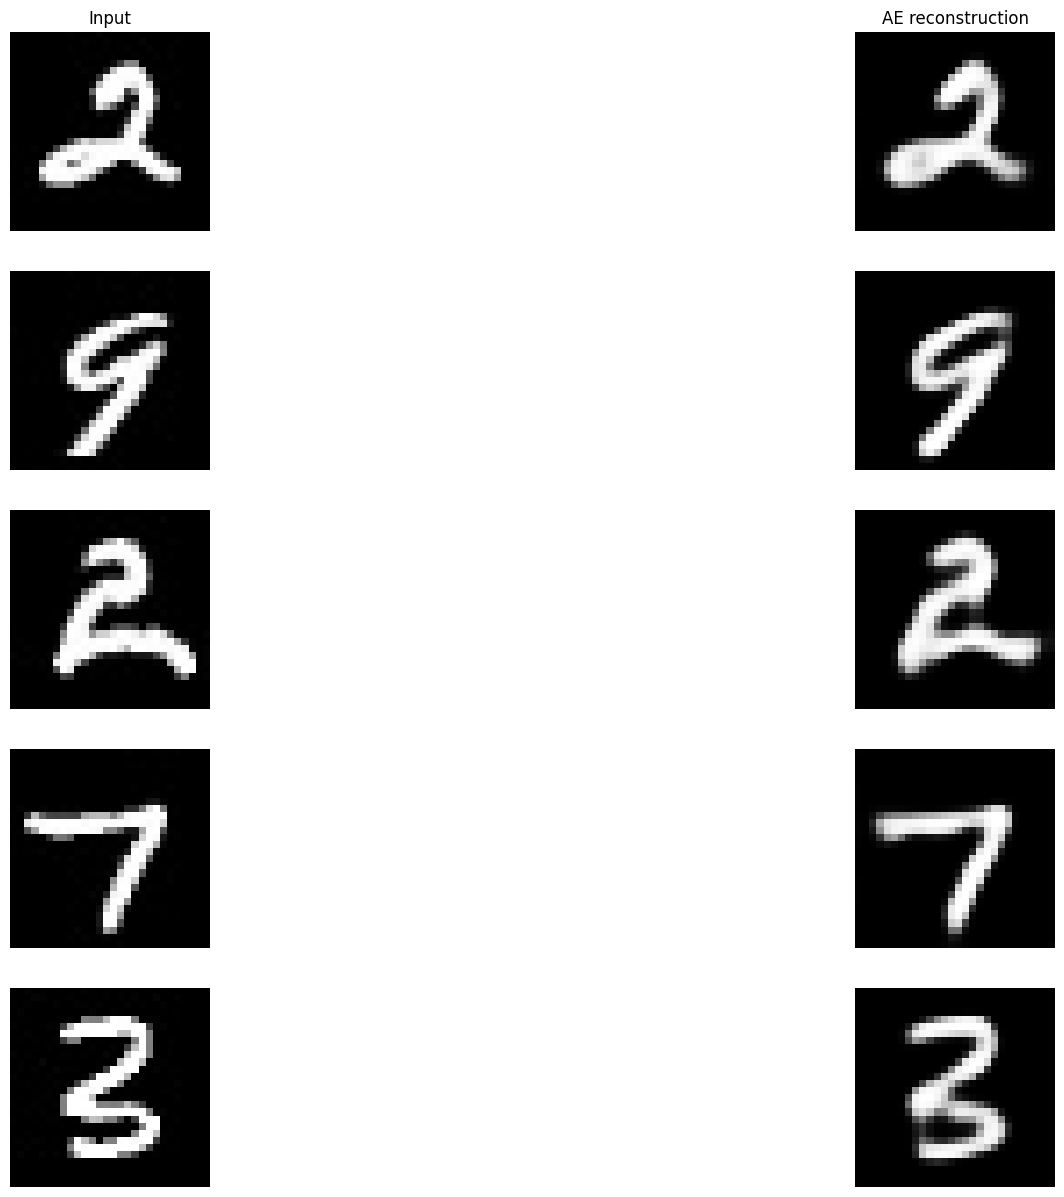

In [26]:
indices = np.random.choice(range(len(mnist_validation_dataset)), 5, replace=False)
mnist_random_images = [mnist_validation_dataset[idx] for idx in indices]
batch = torch.stack(mnist_random_images, dim=0)
gt_img = batch.to(device)

# run the autoencoder:
mnist_autoencoder.eval()
pred_img = mnist_autoencoder(gt_img)

# plot the images:
imgs_plot = [ el.cpu().squeeze().numpy() for el in gt_img]
pred_plot = [ el.cpu().detach().squeeze().numpy() for el in pred_img]

plot_images([imgs_plot, pred_plot], ["Input", "AE reconstruction"], None)
plt.show()
plt.close()

## CelebA-HQ

In [27]:
#solution
class AutoEncoder(Module):
    
    def __init__(self, bottleneck_size, channel_size=1):
        super().__init__()
        self.bottleneck_size = bottleneck_size
        
        self.c = channel_size
                
        # stride used instead of pooling
        # seems to run fasters on local machine
        self.encode = nn.Sequential(
            nn.Conv2d(self.c, 16, 3, stride=1, padding=1),
            nn.BatchNorm2d(16),                        
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.BatchNorm2d(32),                        
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),                        
            nn.ReLU(),
            
            # bottleneck layers
            nn.Flatten(),
            nn.Linear(8 * 8 * 64, bottleneck_size),
        )

        # stride used instead of pooling
        # seems to run fasters on local machine
        self.decode = nn.Sequential(
            nn.Linear(bottleneck_size, 8 * 8 * 64),
            nn.ReLU(),
            nn.Unflatten(1, torch.Size([64, 8, 8])),   
            # exits bottleneck layers           
            
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),            
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),            
            nn.ReLU(),
            nn.ConvTranspose2d(16, self.c, 3, stride=1, padding=1),
            nn.Sigmoid()
        )
        
    
    def encoder(self,image):        
        code = self.encode(image)        
        return code
    
    def decoder(self,code):
        decoded_image = self.decode(code)
        return decoded_image
    
    def forward(self,image):
        code = self.encoder(image)
        decoded_image = self.decoder(code)
        return decoded_image


In [28]:
celeba_hq_autoencoder = None 
torch_train_celeba_hq = DataLoader(celeba_hq_train_dataset, shuffle=True, batch_size=128, num_workers=0)
torch_validation_celeba_hq = DataLoader(celeba_hq_validation_dataset, shuffle=True, batch_size=128, num_workers=0)
celeba_hq_optimizer = None 


celeba_hq_autoencoder = AutoEncoder(bottleneck_size=10*10, channel_size=3).to(device)
celeba_hq_optimizer = torch.optim.Adam(celeba_hq_autoencoder.parameters(), lr=1e-3, weight_decay=1e-4)

epoch = 50

for e in range(epoch):
    ls = 0
    celeba_hq_autoencoder.train()
    for img in torch_train_celeba_hq:
        #print(img.shape)
        img = img.to(device)

        # generate denoised image
        decoded_img = celeba_hq_autoencoder(img)

        # compute loss
        loss = reconstruction_loss(img, decoded_img)

        # backward pass
        celeba_hq_optimizer.zero_grad()
        loss.backward()
        celeba_hq_optimizer.step()
        
        # accumulate loss
        ls += loss
    
    vl = 0
    celeba_hq_autoencoder.eval()
    for val in torch_validation_celeba_hq:
        val = val.to(device)
        d_img = celeba_hq_autoencoder(val)
        
        # accumulate loss
        vl += reconstruction_loss(val, d_img) 
        
    #print(e, 'train', ls / len(torch_train_celeba_hq), 'validation', vl / len(torch_validation_celeba_hq))      






Save the trained model (Needed for marking)

In [29]:
torch.save(celeba_hq_autoencoder, "models/ex3c.pth")

Load the trained model

In [30]:
celeba_hq_autoencoder = torch.load("models/ex3c.pth")

Showing for 5 samples in the validation set, the input and AE reconstruction, side-by-side.

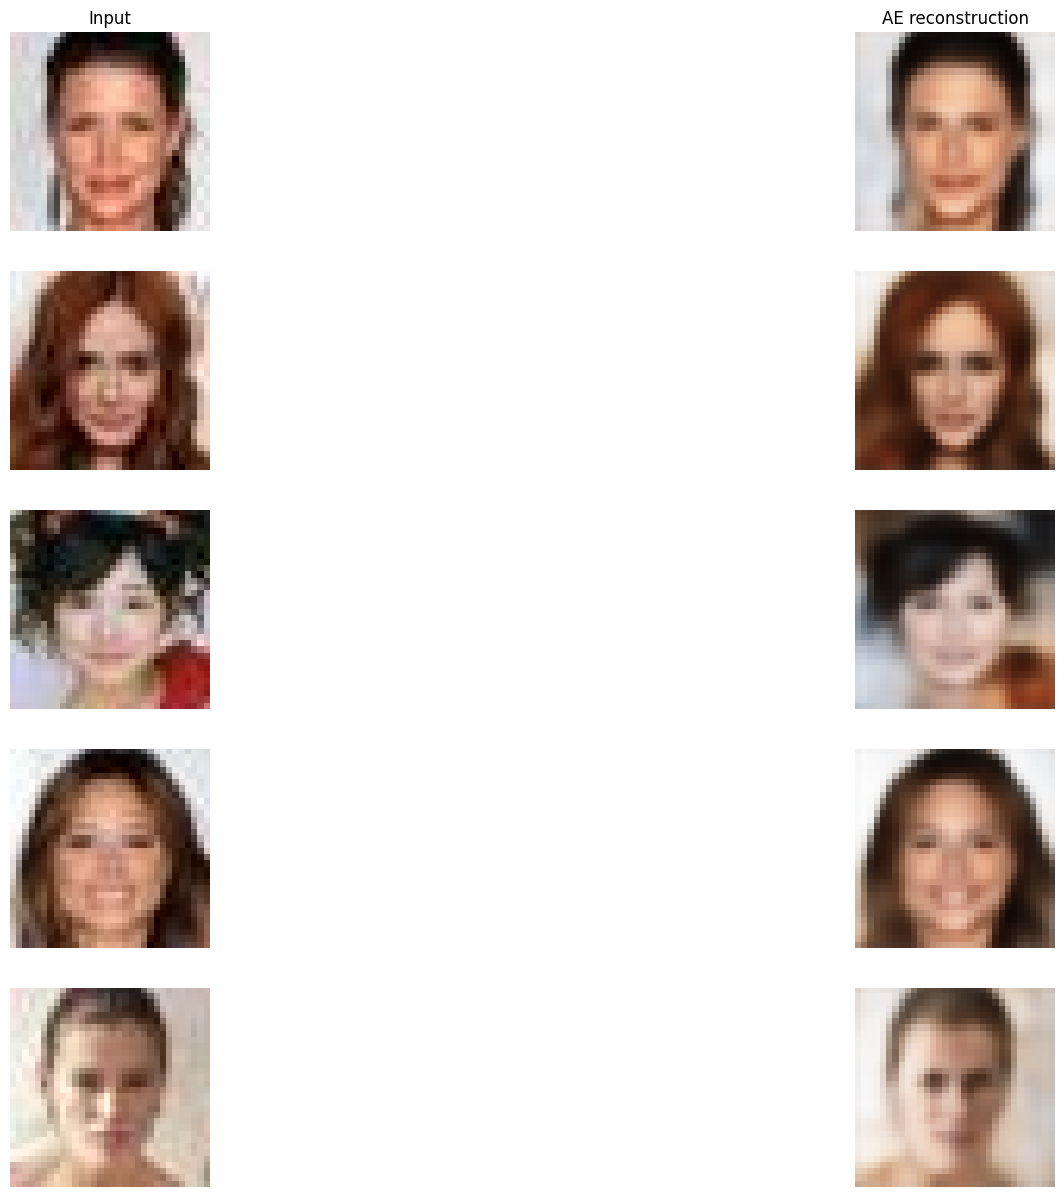

In [31]:
indices = np.random.choice(range(len(celeba_hq_validation_dataset)), 5, replace=False)
celeba_hq_random_images = [celeba_hq_validation_dataset[idx] for idx in indices]
batch = torch.stack(celeba_hq_random_images, dim=0)
gt_img = batch.to(device)

# run the autoencoder:
celeba_hq_autoencoder.eval()
pred_img = celeba_hq_autoencoder(gt_img)

# plot the images:
imgs_plot = [ el.cpu().permute(1, 2, 0).numpy() for el in gt_img]
pred_plot = [ el.cpu().detach().permute(1, 2, 0).numpy() for el in pred_img]

plot_images([imgs_plot, pred_plot], ["Input", "AE reconstruction"], None)
plt.show()
plt.close()